# Week 7 – Feature Engineering with Pipelines

>## Learning goals
>
>By the end of this notebook, you should be able to:
>
> - Review how **preprocessing pipelines** work in scikit-learn.  
> - Load and inspect a **real-world movies dataset** with mixed data types.  
> - Handle **time-based features**.
> - Implement custom cleaning and feature engineering using **`FunctionTransformer`**.  
> - Combine **numeric** and **categorical** preprocessing with `ColumnTransformer`.  
> - Build a **full preprocessing pipeline** using `make_pipeline`.
> - Export a fully cleaned and transformed dataset for future use.
___
**Install the required packages**

In [1]:
# uncomment the following line to install the required package
#!pip install IPython
#!pip install scikit-learn

**Import necessary libraries**

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

**Import datetime to handle time data**

In [3]:
import datetime as dt

**Import scikit-learn preprocessing pipelines functions**

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

## 1. Review of Last Class — Preprocessing Pipelines

In the previous class, you:

> - Cleaned the **Adult Income** dataset manually.  
> - Recreated the same logic with **scikit-learn pipelines**.  
> - Built separate pipelines for **numeric** and **categorical** features.  
> - Combined them with `ColumnTransformer`.  
> - Used `set_output(transform="pandas")` to get back a DataFrame.  
> - Exported the cleaned dataset to `.csv`.
>
>**Why was that important?
>
> - The preprocessing steps became **reproducible and consistent**.  
> - You could apply exactly the same transformations to **new data**.  
> - All cleaning logic was concentrated in a **single object** (the pipeline), instead of scattered across many cells.


## 2. The Movies Dataset
>
>In this class, we will work with a subset of **The Movies Dataset** (Kaggle).  
>We will use the file **`movies_dataset.csv`**, which contains thousands of movies with:
>
> - Titles, languages, and textual descriptions  
> - Budget, revenue, popularity, runtime  
> - `release_date` (temporal information!)  
> - Categorical attributes like `status`, `original_language`, `adult`  
> - Some JSON-like fields such as `genres`
>
>**For now, we will focus on:**
>
> - Cleaning a subset of relevant columns  
> - Converting `release_date` into useful features  
> - Building a preprocessing pipeline around this.
___
### Q2.1. Load the dataset and show the first rows
> - use `pd.read_csv("movies_metadata.csv")`.  
> - store the result in a DataFrame named `df`.  
> - display the **first 5 rows** with `df.head()`.

In [5]:
df = pd.read_csv('movies_dataset.csv')
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


### Q2.2. Inspect the basic structure of the dataset
>
> - Check the **shape** → number of rows and columns.  
> - Use `df.info()` to inspect data types and non-null counts.  
> - Use `df.describe()` to inspect basic statistics.
>
>**This helps to identify:**
>
> - which columns are numeric  
> - which columns are objects / strings  
> - where there are missing values or strange types

In [6]:
df.shape

(4803, 24)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

### Q2.3. Create a list of categorical features

In [8]:
# your code here
categorical_features = df.select_dtypes(include=object).columns.to_list()
categorical_features

['genres',
 'homepage',
 'keywords',
 'original_language',
 'original_title',
 'overview',
 'production_companies',
 'production_countries',
 'release_date',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'cast',
 'crew',
 'director']

### Q2.4. Create a list of numeric features

In [9]:
numeric_features = df.select_dtypes(include=np.number).columns.to_list()
numeric_features

['index',
 'budget',
 'id',
 'popularity',
 'revenue',
 'runtime',
 'vote_average',
 'vote_count']

### Q2.5. Inspect the different values of categorical features
>- use the list of categoricals that you have created earlier
>- use `value_count()` or `.unique()`

In [10]:
for col in categorical_features:
    print(f'{df[col].value_counts(dropna=False)}', end='\n\n')

genres
Drama                                      370
Comedy                                     282
Drama Romance                              164
Comedy Romance                             144
Comedy Drama                               142
                                          ... 
Drama Action History War                     1
Horror Documentary Mystery                   1
Adventure Comedy History Romance             1
Adventure Horror Action Science Fiction      1
Comedy Drama Romance TV Movie                1
Name: count, Length: 1169, dtype: int64

homepage
NaN                                  3091
http://www.thehungergames.movie/        4
http://www.missionimpossible.com/       4
http://www.kungfupanda.com/             3
http://www.transformersmovie.com/       3
                                     ... 
http://www.facingthegiants.com/         1
http://thegallowsmovie.com/             1
http://www.indiegamethemovie.com        1
http://www.pithemovie.com/              1
http:/

### Focus for this class
>
>**We will focus on the following columns:**
>
> - **`title`** – movie title (string)  
> - **`original_language`** – language code (categorical)  
> - **`adult`** – whether the movie is for adults (`'True'` / `'False'`)  
> - **`status`** – release status (`Released`, `Rumored`, etc.)  
> - **`release_date`** – when the movie was released  
> - **`budget`** – production budget (numeric, but sometimes `0` or invalid)  
> - **`revenue`** – total revenue (same issues as budget)  
> - **`runtime`** – duration in minutes  
> - **`vote_average`**, **`vote_count`**, **`popularity`** – numeric indicators  
>
>**We will build a pipeline that:**
>
> - Cleans and converts these columns.  
> - Derives time-based features.  
> - Prepares everything for downstream ML tasks.
___

### Q2.6. Explore missing values and strange entries

> - Compute the **percentage of missing values** per column using `df.isna().mean().sort_values(ascending=False)`  
> - Inspect some rows where `release_date` is missing or invalid.  
> - Inspect some rows where `budget` or `revenue` are `'0'` or non-numeric.

This will help you understand **why** we need custom cleaning logic.


In [11]:
missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct

homepage                0.643556
tagline                 0.175724
keywords                0.085780
cast                    0.008953
director                0.006246
genres                  0.005830
overview                0.000625
runtime                 0.000416
release_date            0.000208
original_title          0.000000
id                      0.000000
index                   0.000000
budget                  0.000000
original_language       0.000000
production_countries    0.000000
popularity              0.000000
spoken_languages        0.000000
revenue                 0.000000
production_companies    0.000000
status                  0.000000
vote_average            0.000000
title                   0.000000
vote_count              0.000000
crew                    0.000000
dtype: float64

In [12]:
df[df["release_date"].isna()].head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
4553,4553,0,NaN,NaN,380097,NaN,en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.0,[],[],NaN,0,0.0,[],Released,NaN,America Is Still the Place,0.0,0,NaN,[],NaN


In [13]:
df[df["budget"] == "0"].head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director


## 3. Custom Cleaning Function for Movies

We will now write a **custom cleaning function** that:

> - Converts `release_date` to a proper `datetime` (`errors="coerce"`).  
> - Converts `budget` and `revenue` to numeric using `pd.to_numeric(..., errors="coerce")`.  
> - Replaces **0 values** in `budget` and `revenue` with `NaN` (they usually mean "unknown").  
> - Ensures `adult` is standardized as a simple `'True'` / `'False'` string or boolean.  

This function will **not** be called directly on `df`.  
Instead, we will later wrap it in a **`FunctionTransformer`** to plug it into a pipeline.

### Q3.1. Implement the `basic_movies_cleaning()` function


In [14]:
import numpy as np

def basic_movies_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a cleaned copy of the movies metadata DataFrame.

    Steps:
    - Convert 'release_date' to datetime (errors='coerce').
    - Convert 'budget' and 'revenue' to numeric (errors='coerce').
    - Replace 0 values in 'budget' and 'revenue' with NaN.
    - Normalize 'adult' to strings 'True'/'False'.
    """
    df_new = df.copy()

    # Convert release_date to datetime
    df_new["release_date"] = pd.to_datetime(df_new["release_date"], errors="coerce")

    # Convert budget and revenue to numeric
    df_new["budget"] = pd.to_numeric(df_new["budget"], errors="coerce")
    df_new["revenue"] = pd.to_numeric(df_new["revenue"], errors="coerce")

    # Replace 0 with NaN for budget and revenue
    df_new.loc[df_new["budget"] == 0, "budget"] = np.nan
    df_new.loc[df_new["revenue"] == 0, "revenue"] = np.nan

    # Normalize 'adult' column: ensure it's a string 'True' or 'False'
    if "adult" in df_new.columns:
        df_new["adult"] = df_new["adult"].astype(str).str.strip().str.lower()
        df_new["adult"] = df_new["adult"].replace({"true": "True", "false": "False"})

    return df_new


### Q3.2. Test `basic_movies_cleaning` on a small sample
> - Apply the function to a sample using `.sample()` and set `random_state=42`
> - Call `basic_movies_cleaning(df_sample)` and inspect the result.  
> - Check that:
>   - `release_date` is now `datetime64[...]`  
>   - `budget` and `revenue` are numeric  
>   - 0 values in `budget` / `revenue` were replaced by NaN


In [15]:
df_sample = df.sample(100, random_state=42)
df_sample.shape

(100, 24)

In [16]:
df_sample.head(2)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
596,596,70000000,Action Adventure Comedy Thriller,NaN,8427,budapest kidnapping boxer secret agent liberat...,en,I Spy,"When the Switchblade, the most sophisticated p...",13.267631,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-10-31,33561137,97.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Attitude meets espionage.,I Spy,5.2,269,Eddie Murphy Owen Wilson Famke Janssen Keith D...,"[{'name': 'Oliver Wood', 'gender': 2, 'departm...",Betty Thomas
3372,3372,7,Thriller Action Horror Science Fiction Crime,NaN,13006,flooding futuristic police detective,en,Split Second,"In a futuristic London, the rising sea levels ...",4.857028,"[{""name"": ""Entertainment"", ""id"": 7676}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",1992-05-01,5,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He's seen the future. Now he has to kill it.,Split Second,5.7,63,Rutger Hauer Kim Cattrall Michael J. Pollard A...,"[{'name': 'John Hubbard', 'gender': 2, 'depart...",Tony Maylam


In [17]:
basic_movies_cleaning(df_sample)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
596,596,70000000.0,Action Adventure Comedy Thriller,NaN,8427,budapest kidnapping boxer secret agent liberat...,en,I Spy,"When the Switchblade, the most sophisticated p...",13.267631,"[{""name"": ""Columbia Pictures Corporation"", ""id...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-10-31,33561137.0,97.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Attitude meets espionage.,I Spy,5.2,269,Eddie Murphy Owen Wilson Famke Janssen Keith D...,"[{'name': 'Oliver Wood', 'gender': 2, 'departm...",Betty Thomas
3372,3372,7.0,Thriller Action Horror Science Fiction Crime,NaN,13006,flooding futuristic police detective,en,Split Second,"In a futuristic London, the rising sea levels ...",4.857028,"[{""name"": ""Entertainment"", ""id"": 7676}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",1992-05-01,5.0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He's seen the future. Now he has to kill it.,Split Second,5.7,63,Rutger Hauer Kim Cattrall Michael J. Pollard A...,"[{'name': 'John Hubbard', 'gender': 2, 'depart...",Tony Maylam
2702,2702,14000000.0,Drama Mystery Thriller,NaN,18041,college suspense gossip rumor social experiment,en,Gossip,"On a beautiful college campus, something ugly ...",5.833687,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2000-04-21,5108820.0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"It can turn you on, or turn on you.",Gossip,5.5,68,Joshua Jackson James Marsden Kate Hudson Lena ...,"[{'name': 'Graeme Revell', 'gender': 2, 'depar...",Davis Guggenheim
2473,2473,15000000.0,Drama Romance,NaN,5038,barcelona spain menage a trois author,en,Vicky Cristina Barcelona,Two girlfriends on a summer holiday in Spain b...,32.758254,"[{""name"": ""The Weinstein Company"", ""id"": 308},...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2008-08-15,96408652.0,96.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}, ...",Released,Life is the ultimate work of art,Vicky Cristina Barcelona,6.7,1020,Scarlett Johansson Rebecca Hall Javier Bardem ...,"[{'name': 'Javier Aguirresarobe', 'gender': 2,...",Woody Allen
8,8,250000000.0,Adventure Fantasy Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch magic broom school of witchcraft wizardry,en,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2009-07-07,933959197.0,153.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,Daniel Radcliffe Rupert Grint Emma Watson Tom ...,"[{'name': 'Bruno Delbonnel', 'gender': 0, 'dep...",David Yates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,199,140000000.0,Adventure Fantasy Action,http://disney.go.com/disneyvideos/liveaction/p...,22,exotic island blacksmith east india trading co...,en,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 17th-century pira...",271.972889,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-07-09,655011224.0,143.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Prepare to be blown out of the water.,Pirates of the Caribbean: The Curse of the Bla...,7.5,6985,Johnny Depp Geoffrey Rush Orlando Bloom Keira ...,"[{'name': 'Arthur Schmidt', 'gender': 2, 'depa...",Gore Verbinski
561,561,74500000.0,Adventure Drama Family,NaN,1997,brother brother relationship loss of brother c

## 4. Time-based Feature Engineering
>We are going to work now on time features.
>
>The `release_date` is a good feature that can provide us a lot of information
>
> Example of **time-based features**, that can be extracted:
>
> - `release_year`  
> - `release_month`  
> - `release_day`  
> - `release_weekday` (0 = Monday, 6 = Sunday)  
> - `movie_age` (e.g. difference between current year and release year)  
>
>We will implement this in a separate function.  
>Later, both functions will be combined inside a **pipeline**.
___
### Q4.2. First convert `release_date` column to datetime
- use `pd.to_datetime(df['release_date'])`, you can specify the `format='%Y-%m-%d'`

In [18]:
pd.to_datetime(df['release_date'], format='%Y-%m-%d', errors='coerce')

0      2009-12-10
1      2007-05-19
2      2015-10-26
3      2012-07-16
4      2012-03-07
          ...    
4798   1992-09-04
4799   2011-12-26
4800   2013-10-13
4801   2012-05-03
4802   2005-08-05
Name: release_date, Length: 4803, dtype: datetime64[ns]

In [19]:
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d', errors='coerce')
df['release_date'].head(2)

0   2009-12-10
1   2007-05-19
Name: release_date, dtype: datetime64[ns]

### Q4.3. Explore some datetime attributes
- use `dt.year`, `dt.month`, `dt.day` and `dt.weekday`
- inspect weekday closely

In [20]:
df['release_date'].dt.year

0       2009.0
1       2007.0
2       2015.0
3       2012.0
4       2012.0
         ...  
4798    1992.0
4799    2011.0
4800    2013.0
4801    2012.0
4802    2005.0
Name: release_date, Length: 4803, dtype: float64

In [21]:
df['release_date'].dt.month

0       12.0
1        5.0
2       10.0
3        7.0
4        3.0
        ... 
4798     9.0
4799    12.0
4800    10.0
4801     5.0
4802     8.0
Name: release_date, Length: 4803, dtype: float64

In [22]:
df['release_date'].dt.day

0       10.0
1       19.0
2       26.0
3       16.0
4        7.0
        ... 
4798     4.0
4799    26.0
4800    13.0
4801     3.0
4802     5.0
Name: release_date, Length: 4803, dtype: float64

In [23]:
df['release_date'].dt.weekday

0       3.0
1       5.0
2       0.0
3       0.0
4       2.0
       ... 
4798    4.0
4799    0.0
4800    6.0
4801    3.0
4802    4.0
Name: release_date, Length: 4803, dtype: float64

In [24]:
df['release_date'].dt.weekday.min(), df['release_date'].dt.weekday.max()

(0.0, 6.0)

In [25]:
# starts on 0 (Monday) and ends on 6 (Sunday)

### Q4.4. Let's do some datetime comparinsons
- a) Verify for the movies within the minimum, mean, median and maximum date
- b) Verify for the oldest and most recent movies in the dataset
- c) Verify what `dt.datetime.now()` will print as output, then check it out with `Q4.3 attributes` - **Note**: use `.weekday()` instead of `.weekday`
- d) Verify for the difference of the current year and the `release_date` year - what would that difference correspond to

In [26]:
df['release_date'].min()

Timestamp('1916-09-04 00:00:00')

In [27]:
df['release_date'].mean()

Timestamp('2002-12-27 23:45:54.352353280')

In [28]:
df['release_date'].median()

Timestamp('2005-10-03 00:00:00')

In [29]:
df['release_date'].max()

Timestamp('2017-02-03 00:00:00')

In [30]:
df.loc[df['release_date'] == df['release_date'].min()]

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
4592,4592,385907,Drama,NaN,3059,usa naivety intolerance mill marriage,en,Intolerance,"The story of a poor young woman, separated by ...",3.232447,"[{""name"": ""Triangle Film Corporation"", ""id"": 1...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1916-09-04,8394751,197.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Cruel Hand of Intolerance,Intolerance,7.4,60,Lillian Gish Mae Marsh Robert Harron F.A. Turn...,"[{'name': 'Tod Browning', 'gender': 2, 'depart...",D.W. Griffith


In [31]:
df.loc[df['release_date'] == df['release_date'].max()]

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
4255,4255,0,Comedy Family Drama,http://www.growingupsmithmovie.com,426469,NaN,en,Growing Up Smith,"In 1979, an Indian family moves to America wit...",0.71087,[],[],2017-02-03,0,102.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,It’s better to stand out than to fit in.,Growing Up Smith,7.4,7,Roni Akurati Brighton Sharbino Jason Lee Anjul...,"[{'name': 'Frank Lotito', 'gender': 0, 'depart...",Frank Lotito


In [32]:
dt.datetime.now()

datetime.datetime(2025, 12, 12, 4, 35, 39, 278667)

In [33]:
dt.datetime.now().day, dt.datetime.now().month, dt.datetime.now().year, dt.datetime.now().weekday()

(12, 12, 2025, 4)

In [34]:
dt.datetime.now().year - df['release_date'].dt.year

0       16.0
1       18.0
2       10.0
3       13.0
4       13.0
        ... 
4798    33.0
4799    14.0
4800    12.0
4801    13.0
4802    20.0
Name: release_date, Length: 4803, dtype: float64

### Q4.5. Implement `add_time_features()` function
>```python
>   def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
>        """
>        Receives a DataFrame with a 'release_date' column (datetime)
>        and returns a copy with new time-based features:
>        
>        - release_year
>        - release_month
>        - release_day
>        - release_weekday
>        - movie_age (assuming reference year = current year)
>        """
>        df_new = df.copy()
>        df_new.rename(columns={'cat__release_date': 'release_date'}, inplace=True)
>
>        # your code here
>
>        return df_new

In [35]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Receives a DataFrame with a 'release_date' column (datetime)
    and returns a copy with new time-based features:
    
    - release_year
    - release_month
    - release_day
    - release_weekday
    - movie_age (assuming reference year = current year)
    """
    df_new = df.copy()
    df_new.rename(columns={'cat__release_date': 'release_date'}, inplace=True)


    df_new["release_year"] = df_new["release_date"].dt.year
    df_new["release_month"] = df_new["release_date"].dt.month
    df_new["release_day"] = df_new["release_date"].dt.day
    df_new["release_weekday"] = df_new["release_date"].dt.weekday
    df_new["movie_age"] = dt.datetime.now().year - df_new["release_year"]

    return df_new


### Q4.6. Test `add_time_features` after cleaning

> - Take a small sample: `df_sample = df.head()`  
> - First apply `basic_movies_cleaning`  
> - Then apply `add_time_features`  
> - Inspect the new columns using this subset `["title", "release_date", "release_year", "release_month", "release_weekday", "movie_age"]`


In [36]:
# print subset ["title", "release_date", "release_year", "release_month", "release_weekday", "movie_age"]

In [37]:
df_sample = df.head()
df_clean_sample = basic_movies_cleaning(df_sample)
add_time_features(df_clean_sample)[["title", "release_date", "release_year", "release_month", "release_weekday", "movie_age"]]

,title,release_date,release_year,release_month,release_weekday,movie_age
0,Avatar,2009-12-10,2009,12,3,16
1,Pirates of the Caribbean: At World's End,2007-05-19,2007,5,5,18
2,Spectre,2015-10-26,2015,10,0,10
3,The Dark Knight Rises,2012-07-16,2012,7,0,13
4,John Carter,2012-03-07,2012,3,2,13


**We are still on the surface of what we can do with `datetime` columns**
- We are going to change the column back to object just to make it as it were before playing a bit with some functions
- Remember that we are going to handle the conversion of this column in our pipeline
___
### Q4.6. Cast the `release_date` column back to object
>- use `.astype(str)`

In [38]:
df['release_date'] = df['release_date'].astype(str)
df['release_date'].head()

0    2009-12-10
1    2007-05-19
2    2015-10-26
3    2012-07-16
4    2012-03-07
Name: release_date, dtype: object

### 5. Recap
>
>Up until now, what have we done?
>
>It seems huge because we gradually built our workflow...
___
### Q5.1. Take this moment to look back and summarize in steps what we have accomplished so far

your answer here

## 6. Choosing Numeric and Categorical Features

We now decide which columns will be treated as **numeric** and which as **categorical** for preprocessing.

For this class, we will:

> - Select the following column from **categorical** list for preprocessing:
>   - `status`  
> - Consider all remaining **non-datetime** numeric columns as **numeric features**.  
> - Ignore long text fields like `overview`, `tagline` for now.

### Q6.1.Select the features for preprocessing
> - create the `encode_features` list
> - remove `release_date` if present (datetime) in numeric or categorical list

In [39]:
encode_features = ['status']

In [40]:
'release_date' in numeric_features

False

In [41]:
'release_date' in categorical_features

True

## 7. Numeric and Categorical Preprocessing Pipelines

We now define:

> - `numeric_pipeline`
>   - Imputes missing values with the **median**.  
>   - Scales features using `StandardScaler`.  
>
> - `categorical_pipeline`
>   - Imputes missing values with the most frequent category.
>
> - `encode_pipeline`
>   - Imputes missing values with the most frequent category.
>   - Encodes categories using `OneHotEncoder` with `handle_unknown="ignore"`.
___
### Q7.1. Implement `numeric_pipeline`, `categorical_pipeline` and `encode_pipeline`
- use the following:
>```python
>numeric_pipeline = Pipeline([
>    ("imputer", SimpleImputer(strategy="median")),
>    ("scaler", StandardScaler()),
>])
>
>categorical_pipeline = Pipeline([
>    ("imputer", SimpleImputer(strategy="most_frequent")),
>])
>
>encode_pipeline = Pipeline([
>    ("imputer", SimpleImputer(strategy="most_frequent")),
>    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
>])
>```

In [42]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

encode_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

> **Note on One-Hot Encoding Output**
>
> By default, `OneHotEncoder` can return a **sparse matrix**.
> In this notebook, we set `sparse_output=False` so that the output is a **dense array**.
>
>   **Example of Dense Output:**
>```console
>                language_en  language_fr  language_pt
>           0    1            0            0
>           1    0            1            0
>           2    0            0            1
>```
>   - Dense arrays are easier to convert into pandas DataFrames.
>
>   **Example of Sparse Output:**
>```console
>           (0, 0)	1
>           (1, 1)	1
>           (2, 2)	1
>```
>   - Each row shows:
>       - the **position** `(row_index, column_index)`  
>       - the **value** at that position  
>       - all other positions are implicitly **zero**.


## 8. Combine Everything with `ColumnTransformer`

We now combine the two preprocessing pipelines into a single `ColumnTransformer` that:

> - Applies `numeric_pipeline` to `numeric_features`  
> - Applies `categorical_pipeline` to `categorical_features`  
> - Drops remaining columns (the default behavior)
>
>**Example:**
>```python
>   full_preprocessor = ColumnTransformer(
>        transformers=[
>            ("num", numeric_pipeline, numeric_features),
>            ("cat", categorical_pipeline, categorical_features),
>            ("enc", encode_pipeline, encode_features),
>        ],
>        remainder="passthrough",
>        verbose_feature_names_out=False
>    )
>```
>
>**Note 1: The parameter `remainder="passthrough"` will keep the new columns generated and make them passthrough the rest of the pipeline** 
>**Note 2: The parameter `verbose_feature_names_out=False` will mantain the original name of the columns** 
___
### Q8.1. Create `full_preprocessor`



In [43]:
full_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
        ("enc", encode_pipeline, encode_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

## 9. Full Movies Preprocessing Pipeline

We can now create a **single pipeline** that:

> 1. Applies `basic_movies_cleaning`  
> 2. Applies `add_time_features`  
> 3. Applies `full_preprocessor` (numeric + categorical + encode)

We will use `make_pipeline` again and finally call `set_output(transform="pandas")` so that the final result is a **DataFrame**, not a NumPy array.

### Q9.1. Create `full_pipeline`


In [44]:
full_pipeline = make_pipeline(
    FunctionTransformer(basic_movies_cleaning, validate=False),
    FunctionTransformer(add_time_features, validate=False),
    full_preprocessor,
)

full_pipeline.set_output(transform="pandas")
full_pipeline

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function basic_movies_cleaning at 0x000002AF7DE6A340>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_time_features at 0x000002AF0049C860>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strat...
                                                   'original_title', 'overview',
                                                   'production_companies',
                                                   'production_countries',
                                                   'release_date',
                                                   'spoken_languages', 'status',
                                                   'tagline', 'title', 'cast',
                                                   'crew', 'director']),
                                                 ('enc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['status'])],
                                   verbose_feature_names_out=False))])

## 10. Visualizing the Preprocessing Pipeline (Diagram)

Scikit-learn can generate an **HTML diagram** of the entire pipeline using:

> - `sklearn.utils.estimator_html_repr`  
> - `IPython.display.HTML`

This is extremely useful to **inspect the structure** of your preprocessing workflow.

### Q10.1. Generate the HTML representation of `full_pipeline`
>
> ⚠️ The diagram may not render outside Jupyter, but should work in a classic notebook environment.


In [45]:
from sklearn.utils import estimator_html_repr
from IPython.display import HTML

HTML(estimator_html_repr(full_pipeline))

## 11. Apply the Full Pipeline to the Movies Dataset

We now apply all steps in a **single call**:

> - custom cleaning  
> - time-based feature engineering  
> - numeric and categorical preprocessing  

### Q11.1. Apply `full_pipeline` to `df` and inspect the result

> - Store the result in `df_clean`.  
> - Show the first 5 rows.  
> - Print the final shape (rows, columns).


In [46]:
df_clean = full_pipeline.fit_transform(df)

In [47]:
df_clean.head()

,index,budget,id,popularity,revenue,runtime,vote_average,vote_count,genres,homepage,keywords,original_language,original_title,overview,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,cast,crew,director,status_Post Production,status_Released,status_Rumored,release_year,release_month,release_day,release_weekday,movie_age
0,-1.731690,5.314186,-0.419128,4.053183,17.171563,2.438652,0.927451,8.999729,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron,0.0,1.0,0.0,2009.0,12.0,10.0,3.0,16.0
1,-1.730969,6.963505,-0.641374,3.696258,5.510592,2.748318,0.676297,3.086200,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski,0.0,1.0,0.0,2007.0,5.0,19.0,5.0,18.0
2,-1.730248,5.523623,1.685526,2.699638,4.997899,1.819320,0.173990,3.058657,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes,0.0,1.0,0.0,2015.0,10.0,26.0,0.0,10.0
3,-1.729527,5.654522,-0.091779,2.854798,6.301658,2.571366,1.262322,6.817394,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan,0.0,1.0,0.0,2012.0,7.0,16.0,0.0,13.0
4,-1.728805,5.916318,-0.086108,0.705198,1.190391,1.111513,0.006554,1.161467,Action Adventure Science Fiction,http://movies.disney.com/john-carter,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton,0.0,1.0,0.0,2012.0,3.0,7.0,2.0,13.0


In [48]:
df_clean.shape

(4803, 32)

## 12. Export the Cleaned Movies Dataset

Finally, we export the processed dataset to a `.csv` file so that it can be reused in future notebooks or a Machine Learning course.

### Q12.1. Save `df_clean` as `clean_movies_preprocessed.csv` (no index).


In [49]:
df_clean.to_csv("clean_movies_preprocessed.csv", index=False)

---

## 13. Extra Exercises

> These are optional but recommended exercises if you want to deepen your understanding.

### Q13.1. Create a `profit` and `roi` feature

> - `profit = revenue - budget`  
>
> - **roi == Return of Investment**
>   - `roi = revenue / budget` (be careful with division by zero / NaN)

In [50]:
# profit
df_clean["profit"] = df_clean["revenue"] - df_clean["budget"]

# roi (handle division by zero or missing values)
df_clean["roi"] = df_clean["revenue"] / df_clean["budget"].replace(0, np.nan)

### Q13.2. Verify the number of movies released per year and plot
- use `.groupby('release_year').size()`
- use `.plot(kind='line')`

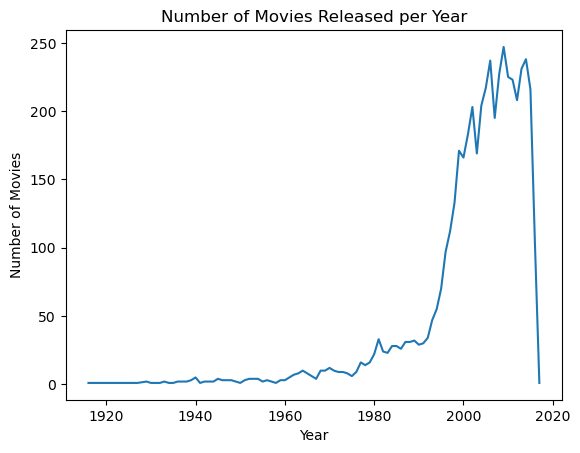

In [51]:
df_clean.groupby("release_year").size().plot(kind="line")

plt.title("Number of Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()

### Q13.3. Verify the average budget per year and plot
- use `.groupby("release_year")["budget"].mean()`
- use `.plot(kind='line')`

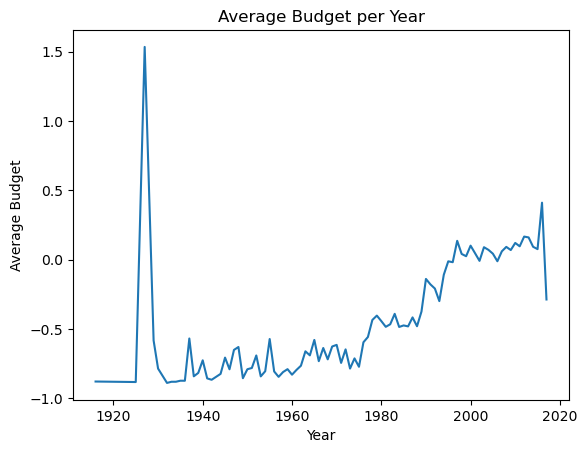

In [52]:
df_clean.groupby("release_year")["budget"].mean().plot(kind="line")

plt.title("Average Budget per Year")
plt.xlabel("Year")
plt.ylabel("Average Budget")
plt.show()

### Q13.4. Verify Monthly distribution of releases and plot
- use `df_clean.groupby("release_month").size()`
- use `.plot(kind='line')`

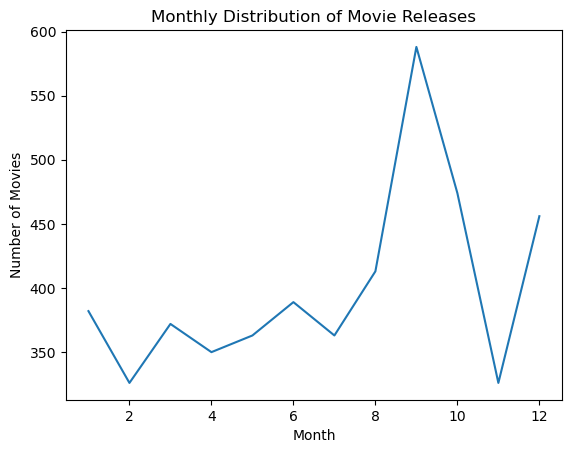

In [53]:
df_clean.groupby("release_month").size().plot(kind='line')

plt.title("Monthly Distribution of Movie Releases")
plt.xlabel("Month")
plt.ylabel("Number of Movies")
plt.show()

### Q13.5. Verify movies released by weekday and plot

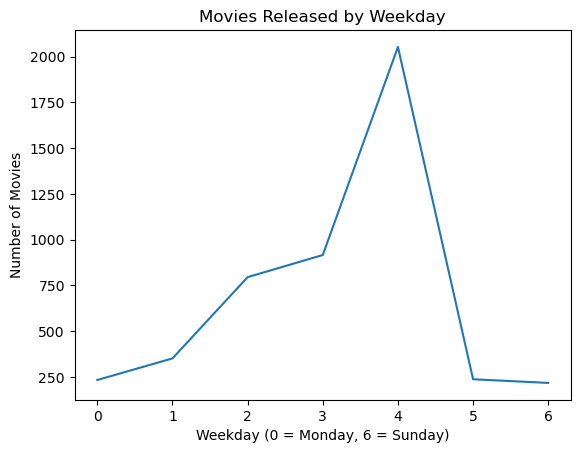

In [54]:
df_clean.groupby("release_weekday").size().plot(kind='line')

plt.title("Movies Released by Weekday")
plt.xlabel("Weekday (0 = Monday, 6 = Sunday)")
plt.ylabel("Number of Movies")
plt.show()

### Q13.6. Verify the average popularity by movie age and plot
- use `.groupby("movie_age")["popularity"].mean()`
- use `.plot(kind='line')`

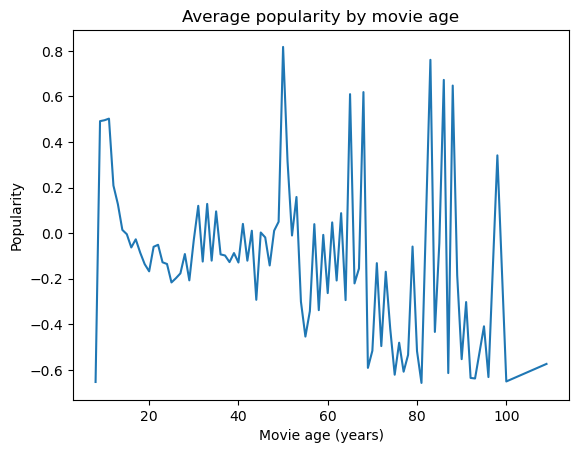

In [55]:
df_clean.groupby("movie_age")["popularity"].mean().plot(kind="line")
plt.title("Average popularity by movie age")
plt.xlabel("Movie age (years)")
plt.ylabel("Popularity")
plt.show()


### 🎬🍿 After those exercises you have earned the right to watch some movies!
>
>**Whether you prefer:**
>🎭 drama
>🚀 sci-fi
>😂 comedy
>🦸 action
>🧙‍♂️✨ fantasy
>💘 romance
>
>…go treat yourself to a well-earned film session! 🎞️🍫